# <div align=center> Analyzing the Supply Chain Network </div>
# <div align=center> Created from the Conventional Relation Extraction Model and Chat-GPT: </div>
# <div align=center> Focusing On S&P 500 Companies </div>
###  <div align=center> Jeong Yeo(faiiry9@kaist.ac.kr); Jaejun Kim(jaejun.kim305@gmail.com); Ilju Park(dlfwnqkr12@gmail.com); Moon Il-chul(icmoon@kaist.ac.kr)<br/> </div>
본 코드는 ChatGPT와 SSAN 모델을 활용하여 S&P 500 기업들의 10K 리포트로부터 relation extraction한 데이터를 활용하여 supply chain network를 구축하는 과정 및 결과를 보여줍니다.
### SSAN Model Relation Extraction 과정
1) 문서내의 개체간의 종속성을 추출합니다.
2) 종속성을 모델링하기 위해 각 층에 self-attention을 활용합니다.
3) transformation module을 이용하여 attentive bias를 생성합니다.
* Binary relation prediction:
$$ P(r|e_s, e_o) = \text{sigmoid}(e_s^T W_r e_o), \text{ where } e_s \in \mathbb{R}^{d_e}, W_r \in \mathbb{R}^{d_e d_e} $$

* Cross Entropy Loss:
$$ L = \sum_{<s,o>}\sum_{r} \text{CrossEntropy}(P(r|e_s, e_o), y_r(e_s, e_o))\text{, where y = target label}$$

#### SSAN Architecture
<img src = 'https://raw.githubusercontent.com/BenfengXu/SSAN/master/SSAN.png' alt = 'SSAN' width = '800'/>

Xu, B., Wang, Q., Lyu, Y., Zhu, Y., & Mao, Z. (2021). Entity structure within and throughout: Modeling mention dependencies for document-level relation extraction. Proceedin gs of the AAAI Conference on Artificial Intelligence, 35(16), 14149–14157. doi:10.1609/aaai.v35i16.17665

### GPT Relation Extraction 과정
1) 문서 전체를 처리하여 문맥, 객체 및 관계를 이해합니다.
2) 객체와 관계의 언어적 패턴을 식별합니다.
3) 사전 학습된 지식을 바탕으로 관계를 추론합니다.

# 0. Initial Setting

In [ ]:
import pickle
import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import re
from tabulate import tabulate
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib_venn import venn3, venn2
from tqdm import tqdm
from collections import defaultdict, Counter
import seaborn as sns
from community import community_louvain
import dataframe_image as dfi
import random
from datasets import load_dataset
pd.set_option('display.max_colwidth', 200)
%matplotlib inline

# 1. Dataload
본 섹션에서는 SSAN과 GPT로 추출한 entity와 relation의 데이터프레임을 불러오고 관계 그래프를 시각화합니다.

In [73]:
def making_DF(csv_name, company):
    df = pd.read_csv('{}.csv'.format(csv_name))#.iloc[:,1:]
    #print(df.isna().sum())

    df = df.dropna(subset=['num_para'], how='any', axis=0)
    #print(df.isna().sum())

    gpt_rel = df[df['relations'].notnull()]
    gpt_rel = gpt_rel.reset_index(drop=True)

    #print('=======DATA LOAD DONE========')


    # 한 문단 당 relations들 한 리스트로 만들기 i.e.['1. Company @ strategic alliance @ None', '2. Company @ Caterpillar Inc. @ strategic alliance', ..]
    rel_li = []
    rel_index_li = []
    for idx, rel in enumerate(gpt_rel['relations']):
        if '\n' in rel:
            rel_li.append(rel.split('\n'))
            #print(rel.split('\n'))
            for i in range(len(rel.split('\n'))):
                rel_index_li.append(idx)
                #print(idx)
            #print('='*20)
        else:
            if '1. (' in rel:
                rel_li.append(rel)
                #print(rel)
                #print('='*20)
                rel_index_li.append(idx)

    #print('=======RELs to a LIST DONE========')


    # 한 리스트로 만들기
    import itertools

    def from_iterable(iterables):
        for it in iterables:
            for element in it:
                yield element

    rel_li = list(itertools.chain(*rel_li)) 

    #print('=======MAKING ONE REL LIST DONE========')

    # 넘버링 떼기
    rels_li = []
    idx_li = []
    for idx, rel in enumerate(rel_li):
        if rel[1:3]== '. ':
            if rel[3]=='(':
                rels_li.append(rel[4:-1])
                idx_li.append(rel_index_li[idx])
            else:
                rels_li.append(rel[3:])
                idx_li.append(rel_index_li[idx])
        elif rel[2:4]== '. ':
            if rel[4]=='(':
                rels_li.append(rel[5:-1])
                idx_li.append(rel_index_li[idx])
            else:
                rels_li.append(rel[4:])
                idx_li.append(rel_index_li[idx])
    print('len of idx and rel:', len(idx_li), len(rels_li))
    #print('=======REMOVING NUMBERING DONE========')

    # @ 기준으로 h,t,r로 나누기
    r_li = []
    para_li = []
    for rel, idx in zip(rels_li,idx_li):
        if len(rel.split(' @ '))==3:
            if 'entity' not in rel.split(' @ ')[0] and 'entity' not in rel.split(' @ ')[1]:
                r_li.append(rel.split(' @ '))
                para_li.append(gpt_rel['para'].iloc[idx][:-1])
        # else:
            # print(rel.split(' @ '))
    #print('=======DEVIDE h,t,r DONE========')



    #================================================

    # df로 만들기
    kg_df = pd.DataFrame(r_li, columns = ['source','target','edge'])
    kg_df['para'] = para_li
    kg_df = kg_df.drop_duplicates()#keep='last')

    #print('=======MAKING DF DONE========')

    # edge = none인 행 제거
    nem_df = kg_df.dropna(subset=['edge'], how='any', axis=0)
    # print(nem_df.isna().sum())

    none_row = nem_df[nem_df['source']=='None'].index
    NEM_df = nem_df.drop(none_row, inplace=False)
    nem_df  = NEM_df.reset_index(drop=True)

    none_row = nem_df[nem_df['target']=='None'].index
    NEM_df = nem_df.drop(none_row, inplace=False)
    nem_df  = NEM_df.reset_index(drop=True)

    none_row = nem_df[nem_df['edge']=='None'].index
    NEM_df = nem_df.drop(none_row, inplace=False)
    NEM_df  = NEM_df.reset_index(drop=True)

    #print('=======REMOVING ROW: None in h,t,r DONE========')

    # # entity라고 나온거 제거
    # given_rel = ["head of government", "country", "place of birth", "place of death", "father", "mother", "spouse", "country of citizenship", "continent", "instance of", "head of state", "capital", "official language", "position held", "child", "author", "member of sports team", "director", "screenwriter", "educated at", "composer", "member of political party", "employer", "founded by", "league", "publisher", "owned by", "located in the administrative territorial entity", "genre", "operator", "religion", "contains administrative territorial entity", "follows", "followed by", "headquarters location", "cast member", "producer", "award received", "creator", "parent taxon", "ethnic group", "performer", "manufacturer", "developer", "series", "sister city", "legislative body", "basin country", "located in or next to body of water", "military branch", "record label", "production company", "location", "subclass of", "subsidiary", "part of", "original language of work", "platform", "mouth of the watercourse", "original network", "member of", "chairperson", "country of origin", "has part", "residence", "date of birth", "date of death", "inception", "dissolved, abolished or demolished", "publication date", "start time", "end time", "point in time", "conflict", "characters", "lyrics by", "located on terrain feature", "participant", "influenced by", "location of formation", "parent organization", "notable work", "separated from", "narrative location", "work location", "applies to jurisdiction", "product or material produced", "unemployment rate", "territory claimed by", "participant of", "replaces", "replaced by", "capital of", "languages spoken, written or signed", "present in work", "sibling"]
    # given_rel_row = []

    # for i in range(len(NEM_df)):
    #     if any(g_rel == NEM_df['edge'][i] for g_rel in given_rel):
    #         given_rel_row.append([NEM_df['source'][i],NEM_df['target'][i],NEM_df['edge'][i]])
    # #print('=======REMOVING ROW: None in h,t,r DONE========')

    # given rel에 존재하는 데이터만 저장
    given_rel = ["head of government", "country", "place of birth", "place of death", "father", "mother", "spouse", "country of citizenship", "continent", "instance of", "head of state", "capital", "official language", "position held", "child", "author", "member of sports team", "director", "screenwriter", "educated at", "composer", "member of political party", "employer", "founded by", "league", "publisher", "owned by", "located in the administrative territorial entity", "genre", "operator", "religion", "contains administrative territorial entity", "follows", "followed by", "headquarters location", "cast member", "producer", "award received", "creator", "parent taxon", "ethnic group", "performer", "manufacturer", "developer", "series", "sister city", "legislative body", "basin country", "located in or next to body of water", "military branch", "record label", "production company", "location", "subclass of", "subsidiary", "part of", "original language of work", "platform", "mouth of the watercourse", "original network", "member of", "chairperson", "country of origin", "has part", "residence", "date of birth", "date of death", "inception", "dissolved, abolished or demolished", "publication date", "start time", "end time", "point in time", "conflict", "characters", "lyrics by", "located on terrain feature", "participant", "influenced by", "location of formation", "parent organization", "notable work", "separated from", "narrative location", "work location", "applies to jurisdiction", "product or material produced", "unemployment rate", "territory claimed by", "participant of", "replaces", "replaced by", "capital of", "languages spoken, written or signed", "present in work", "sibling"]
    given_rel_row = []

    for i in range(len(NEM_df)):
        if any(g_rel == NEM_df['edge'][i] for g_rel in given_rel):
            given_rel_row.append([NEM_df['para'][i],NEM_df['source'][i],NEM_df['target'][i],NEM_df['edge'][i]])

    final_DF2 = pd.DataFrame(given_rel_row, columns = ['para','source','target','relation'])

    final_DF = final_DF2[['source','target','relation']]


    #print('=======EXTRACTING JUST GIVEN REL DONE========')

    # 저장 
    final_DF.to_csv('./{}_DF1.csv'.format(company))
    #print('=======SAVE AS DF DONE========')
    final_DF2.to_excel(excel_writer='./{}.xlsx'.format(company)) 
    #dfi.export(final_DF, './RESULT/{}_RE_By_{}.png'.format(company, 'GPT'), max_cols=-1, max_rows=-1)

    return final_DF2

In [74]:
# S&P500 기업들의 이름과 티커를 불러옵니다.
url = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
table = pd.read_html(url)
sp500_df = table[0]

# 티커와 회사명을 딕셔너리로 매핑
ticker_to_name = pd.Series(sp500_df.Security.values, index=sp500_df.Symbol).to_dict()


In [75]:
# example: first 10 companies
for ticker, name in list(ticker_to_name.items())[:10]:
    print(f'{ticker}: {name}')

MMM: 3M
AOS: A. O. Smith
ABT: Abbott
ABBV: AbbVie
ACN: Accenture
ADBE: Adobe Inc.
AMD: Advanced Micro Devices
AES: AES Corporation
AFL: Aflac
A: Agilent Technologies


In [76]:
# 추출된 entity와 관계의 데이터프레임을 불러옵니다.
gpt_tag = pd.read_csv('GPT_SP_DF_TAG.csv')
gpt_tag.head(5)

,para,source,target,relation,source_ner_2,target_ner_2,source_ner_4,target_ner_4,company,source_ner_3,target_ner_3,source_ner,target_ner,sorted_pair
0,"Indicate by check mark if the registrant is a well-known seasoned issuer, as defined in Rule 405 of the Securities Act. Ye",registrant,well-known seasoned issuer,instance of,Unknown,Unknown,Unknown,Unknown,GOOGL,Unknown,Unknown,Unknown,Unknown,"('registrant', 'well-known seasoned issuer')"
1,"Indicate by check mark if the registrant is a well-known seasoned issuer, as defined in Rule 405 of the Securities Act. Ye",registrant,Rule 405,head of government,Unknown,FAC,Unknown,FAC,GOOGL,Unknown,FAC,Unknown,Country,"('Rule 405', 'registrant')"
2,"Indicate by check mark if the registrant is a well-known seasoned issuer, as defined in Rule 405 of the Securities Act. Ye",registrant,Securities Act,country,Unknown,Unknown,Unknown,Unknown,GOOGL,Unknown,Unknown,Unknown,Unknown,"('Securities Act', 'registrant')"
3,Indicate by check mark whether the registrant has submitted electronically every Interactive Data File required to be submitted pursuant to Rule 405 of Regulation S-T ( § 232.405 of this chapter )...,registrant,Interactive Data File,instance of,Unknown,ORG,Unknown,ORG,GOOGL,Unknown,ORG,Unknown,Firm,"('Interactive Data File', 'registrant')"
4,Indicate by check mark whether the registrant has submitted electronically every Interactive Data File required to be submitted pursuant to Rule 405 of Regulation S-T ( § 232.405 of this chapter )...,registrant,Rule 405 of Regulation S-T,position held,Unknown,ORG,Unknown,ORG,GOOGL,Unknown,ORG,Unknown,Firm,"('Rule 405 of Regulation S-T', 'registrant')"


* para = pragraph
* source = entity
* target = entity
* relation = relation
* source_ner, target_ner = ner
* sorted_pair
* sorted_pair = entity pair

In [77]:
# number of relations
len(gpt_tag['relation'].unique())

96

총 96개의 관계가 있습니다.
### 각 관계 수 별 bar chart

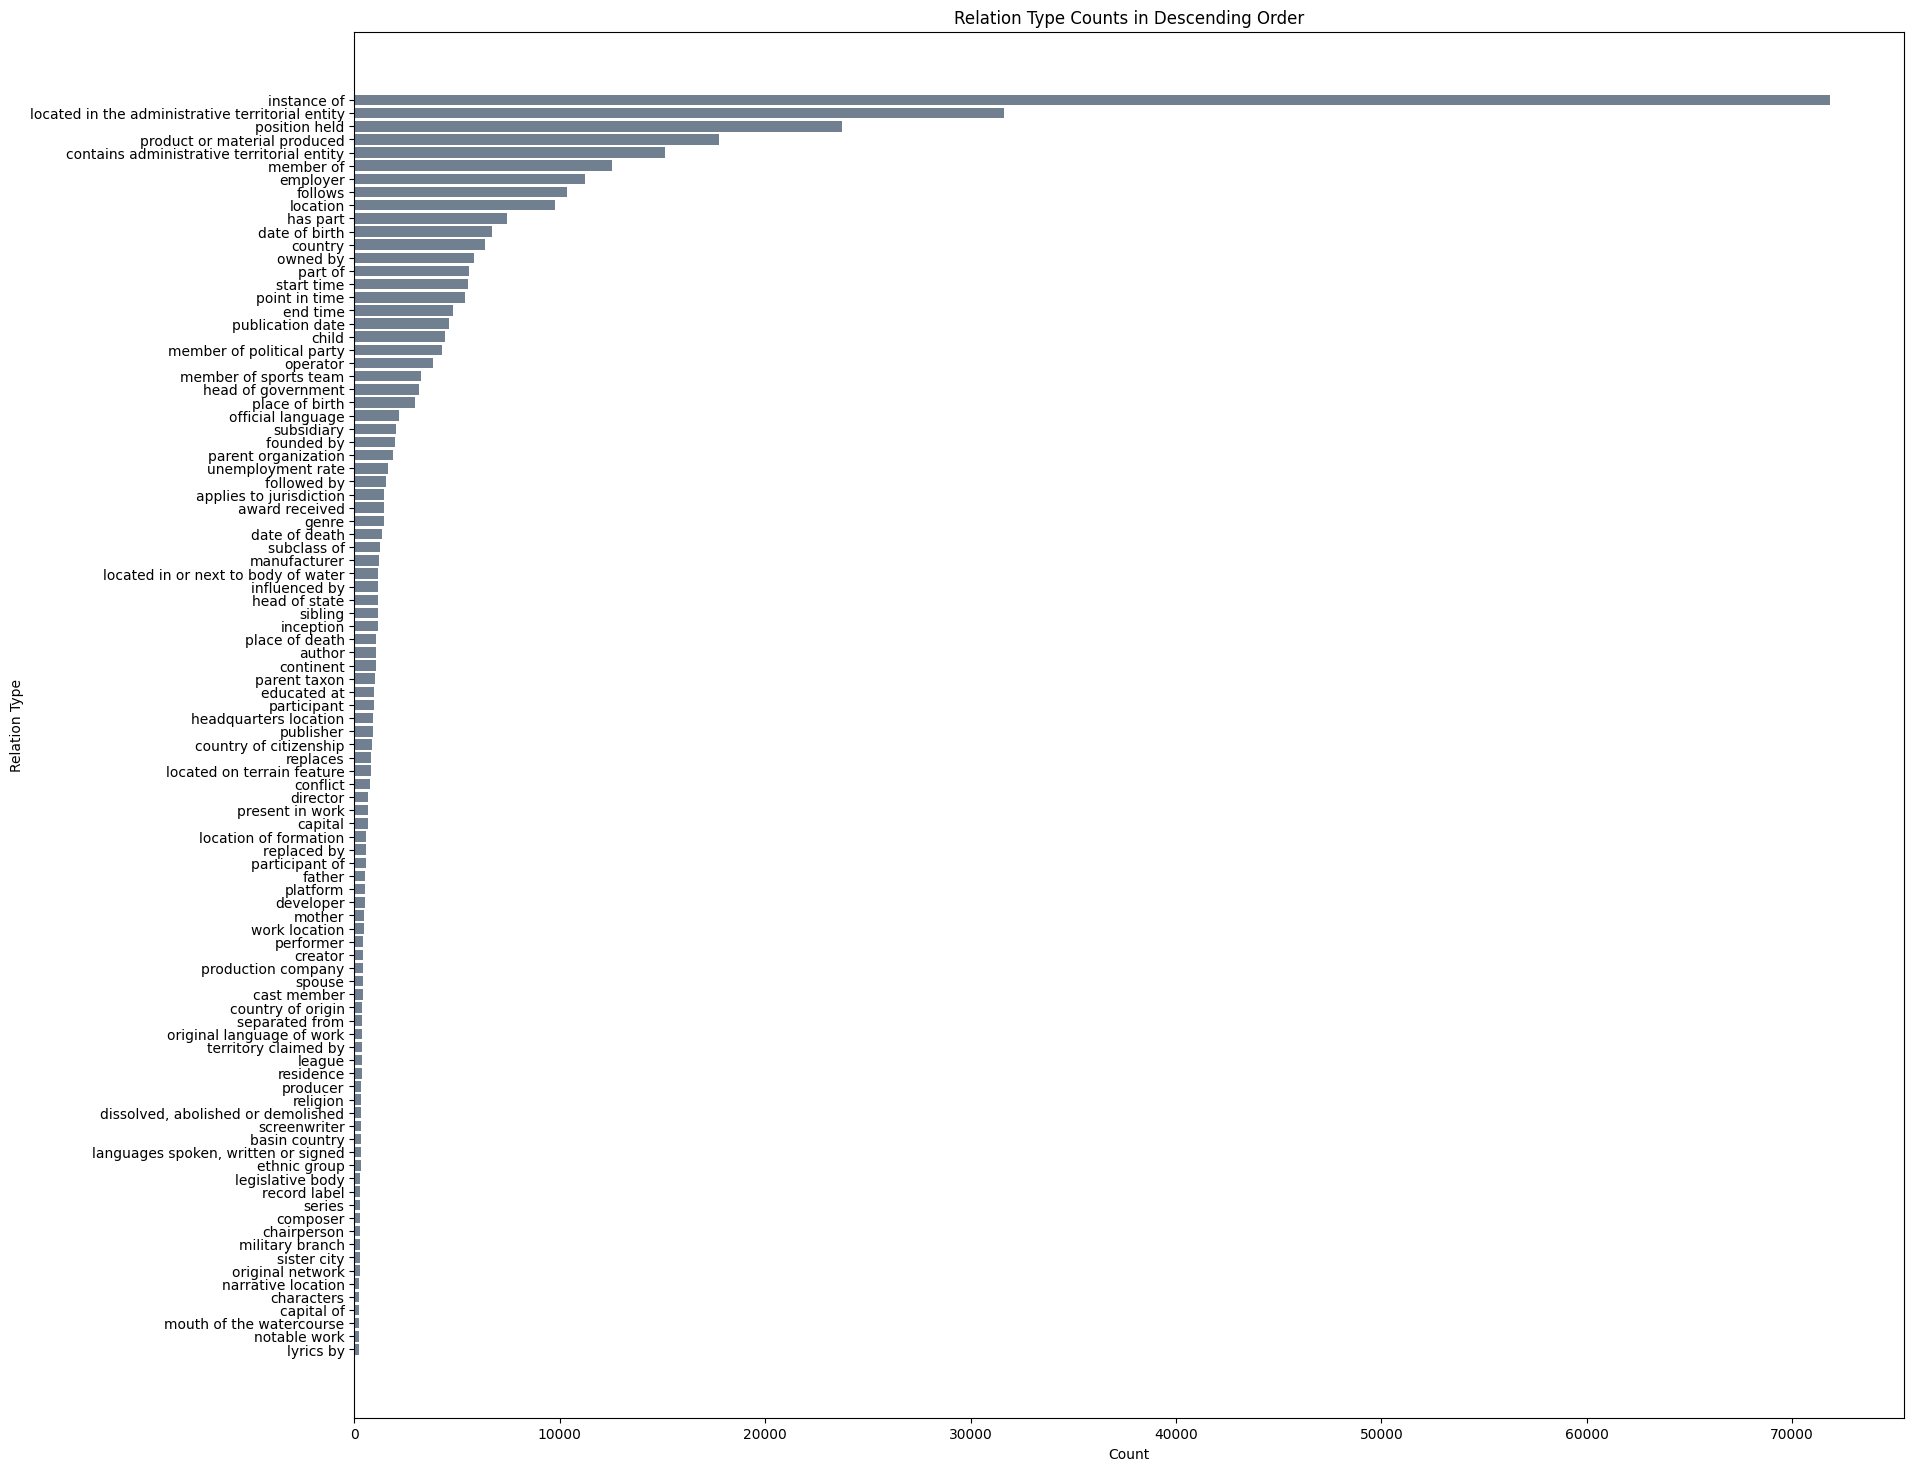

In [78]:
# number of each relations
edge_counts = gpt_tag['relation'].value_counts()

# bar chart of relation type counts
plt.figure(figsize=(20, 18))  # Adjust the size as needed
plt.barh(edge_counts.index, edge_counts.values, color='slategray') 
plt.xlabel('Count')
plt.ylabel('Relation Type')
plt.title('Relation Type Counts in Descending Order')
plt.gca().invert_yaxis()  # To display the highest count at the top
plt.show()

In [79]:
# 데이터를 불러옵니다.
gpt_just = pd.read_csv('GPT_Just_S_T.csv')
gpt_just.head(5)

,para,source,target,relation,source_ner_2,target_ner_2,source_ner_4,target_ner_4,company,source_ner_3,target_ner_3,source_ner,target_ner
0,ANNUAL REPORT PURSUANT TO SECTION 13 OR 15(d ) OF THE SECURITIES EXCHANGE ACT OF 193,ANNUAL,REPORT,official language,GPE,Unknown,GPE,Unknown,yenv/sec-edgar/output/MMM,GPE,DATE,Country,Unknown
1,Indicate by check mark whether the registrant has submitted electronically every Interactive Data File required to be submitted pursuant to Rule 405 of Regulation S-T ( § 232.405 of this chapter...,registrant,Interactive Data File,product or material produced,Unknown,ORG,Unknown,ORG,yenv/sec-edgar/output/MMM,Unknown,ORG,Unknown,Firm
2,Indicate by check mark whether the registrant has submitted electronically every Interactive Data File required to be submitted pursuant to Rule 405 of Regulation S-T ( § 232.405 of this chapter...,registrant,Regulation S-T ( § 232.405 of this chapter ),applies to jurisdiction,Unknown,Unknown,Unknown,Unknown,yenv/sec-edgar/output/MMM,Unknown,Unknown,Unknown,Unknown
3,Indicate by check mark whether the registrant has submitted electronically every Interactive Data File required to be submitted pursuant to Rule 405 of Regulation S-T ( § 232.405 of this chapter...,registrant,the preceding 12 months,start time,Unknown,DATE,Unknown,DATE,yenv/sec-edgar/output/MMM,Unknown,DATE,Unknown,Unknown
4,"If an emerging growth company, indicate by check mark if the registrant has elected not to use the extended transition period for complying with any new or revised financial accounting standards p...",registrant,Section 13(a,instance of,Unknown,LAW,Unknown,LAW,yenv/sec-edgar/output/MMM,Unknown,LAW,Unknown,Unknown


* para = paragraph
* source = entity
* target = entity
* relation = relation
* source_ner, target_ner = ner
* company = company

In [80]:
# Creating a directed graph
G = nx.DiGraph()

# Adding edges from the DataFrame
for _, row in gpt_just.iterrows():
    G.add_edge(row['source'], row['target'], edge=row['relation'])
    
    # Calculate centrality measures (e.g., degree centrality)
centrality = nx.degree_centrality(G)

# Preparing to categorize nodes by their NER tags
node_categories = defaultdict(list)

# source와 target을 딕셔너리로 변환
source_dict = gpt_just.set_index('source')['source_ner'].to_dict()
target_dict = gpt_just.set_index('target')['target_ner'].to_dict()

for node in G.nodes:
    # 딕셔너리를 사용하여 빠르게 노드 카테고리 찾기
    if node in source_dict:
        category = source_dict[node]
    elif node in target_dict:
        category = target_dict[node]
    else:
        category = 'Unknown'
    
    node_categories[category].append(node)
    
# # Sorting nodes in each category by centrality
top_centrality_by_category = {category: sorted(nodes, key=lambda x: centrality[x], reverse=True)[:10]
                              for category, nodes in node_categories.items()}

# top_centrality_by_category
# Converting the top_centrality_by_category dictionary to a DataFrame
df_top_centrality = pd.DataFrame([{"Category": category, "Node": node, "Centrality": centrality[node]}
                                  for category, nodes in top_centrality_by_category.items()
                                  for node in nodes])

df_top_centrality.head(5)

,Category,Node,Centrality
0,Country,U.S.,0.021328
1,Country,United States,0.006780
2,Country,the United States,0.005184
3,Country,Europe,0.003655
4,Country,China,0.003405


### source_node별 subgraph
* source_node = 'Tesla, Inc.'

In [81]:
# computes the shortest path to all nodes reachable from the source_node
# (node: length)
source_node = 'Tesla, Inc.'
reachable_nodes = nx.single_source_shortest_path_length(G, source_node)
list(reachable_nodes.items())[:10]

[('Tesla, Inc.', 0),
 ('COVID-19', 1),
 ('automotive', 1),
 ('energy generation and storage', 1),
 ('Model 3', 1),
 ('Tesla Semi', 1),
 ('Cybertruck', 1),
 ('Tesla Roadster', 1),
 ('Solar Roof', 1),
 ('customers', 1)]

source_node를 'Tesla, Inc.'로 설정했을때 첫 10개의 reachable_nodes입니다.

In [82]:
print(len(list(reachable_nodes.keys())))
# first 100 reachable nodes
first_100_reachable_nodes = dict(list(reachable_nodes.items())[:100])

190269


'Tesla, Inc.'에는 190269개의 reachable nodes가 있고, 그래프를 그리기 위해 100개의 노드만 선택했습니다.

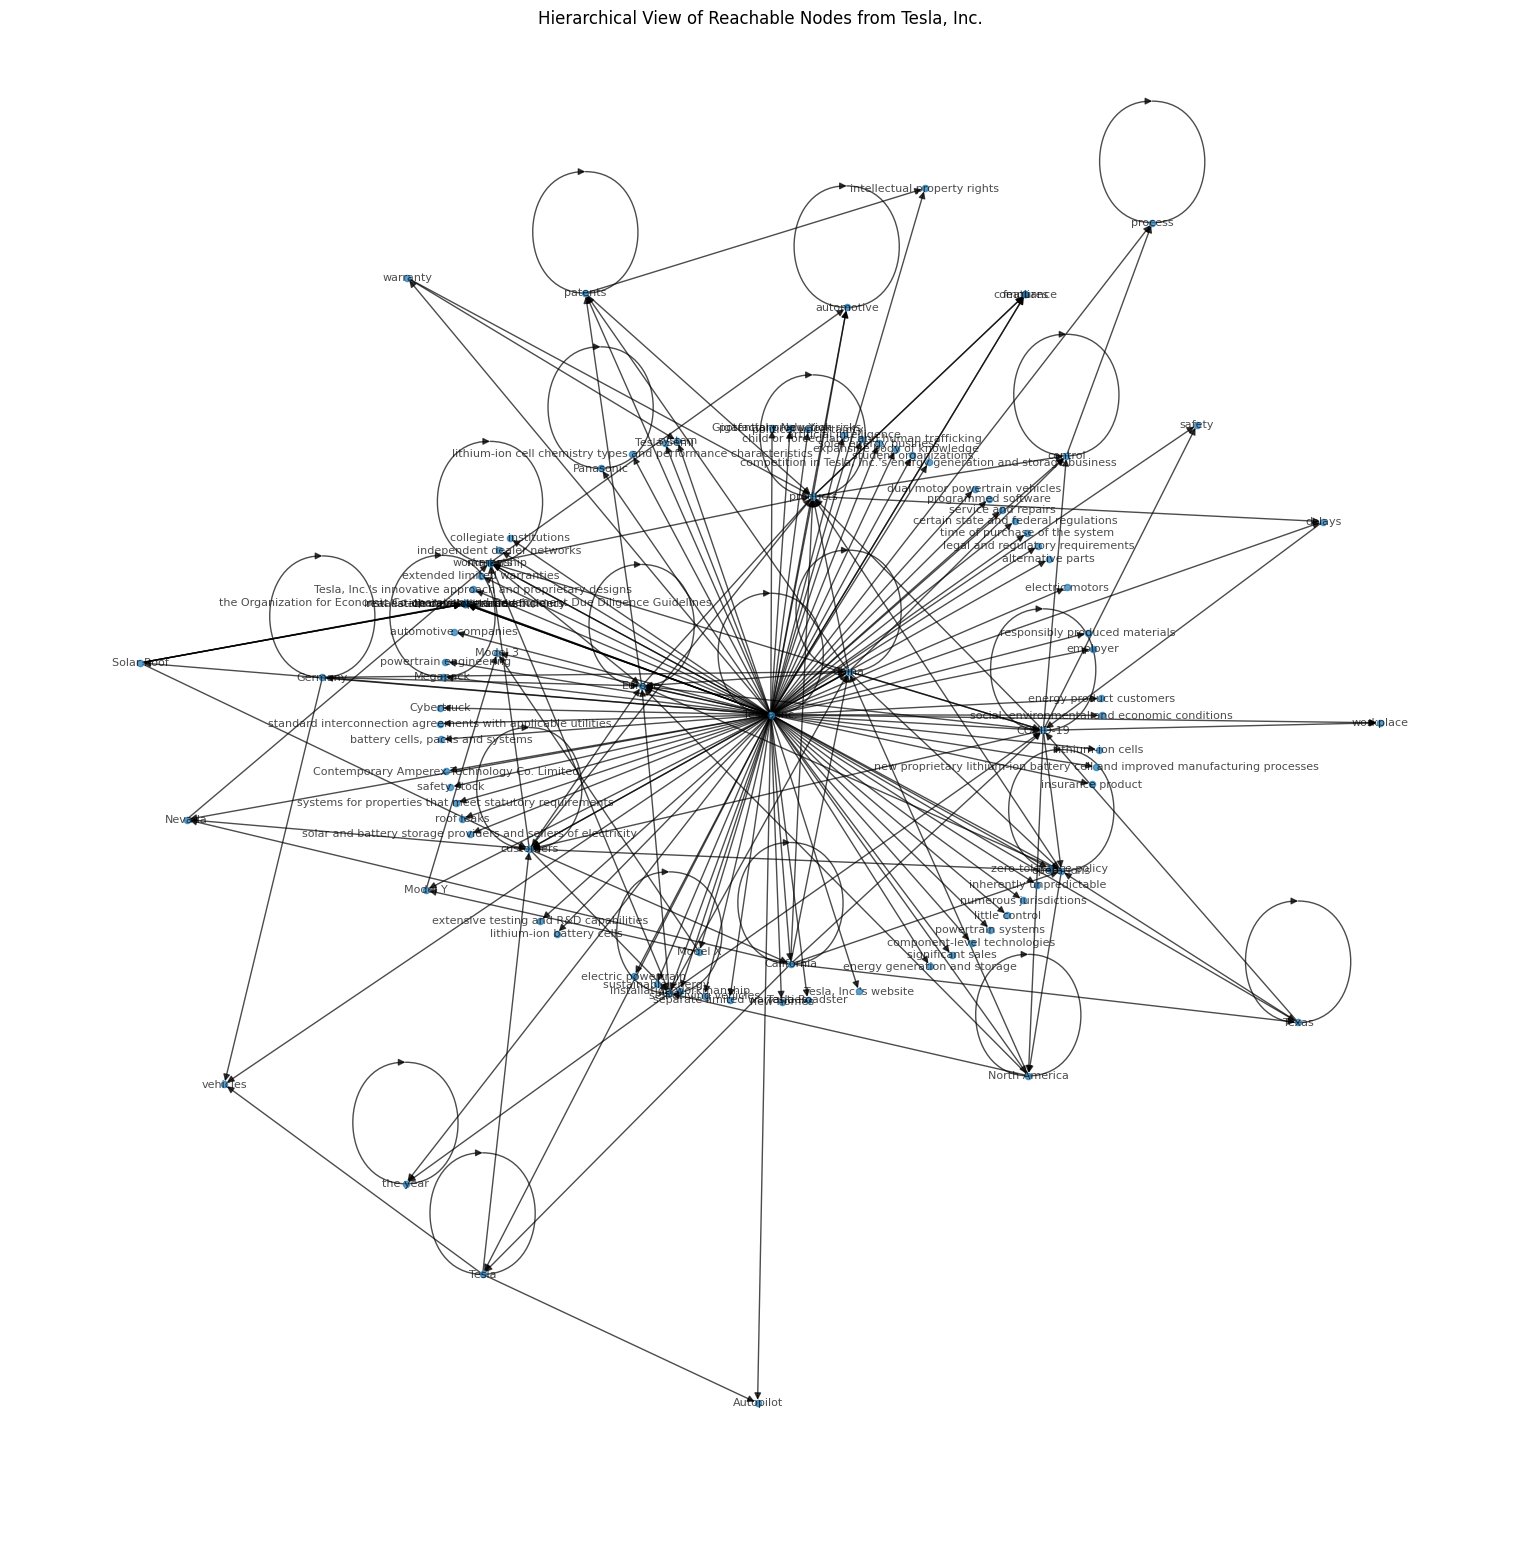

In [83]:
# Extract the subgraph of reachable nodes
subgraph = G.subgraph(first_100_reachable_nodes.keys())

# Use the Kamada-Kawai layout for a hierarchical structure
pos = nx.kamada_kawai_layout(subgraph)

# Draw the subgraph with Kamada-Kawai layout
plt.figure(figsize=(15, 15))
nx.draw(subgraph, pos, with_labels=True, node_size=20, font_size=8, alpha=0.7, arrows=True)
plt.title(f"Hierarchical View of Reachable Nodes from {source_node}")
plt.show()

아래의 코드는 전체 reachable_nodes에 대한 그래프 입니다. 연산량이 많아 주석처리 되어있습니다.

In [84]:
"""
# heavy computation
# source_node can be replaced with other nodes
source_node = 'Tesla, Inc.'
reachable_nodes = nx.single_source_shortest_path_length(G, source_node)

# Extract the subgraph of reachable nodes
subgraph = G.subgraph(reachable_nodes.keys())

# Use the Kamada-Kawai layout for a hierarchical structure
pos = nx.kamada_kawai_layout(subgraph)

# Draw the subgraph with Kamada-Kawai layout
plt.figure(figsize=(15, 15))
nx.draw(subgraph, pos, with_labels=True, node_size=20, font_size=8, alpha=0.7, arrows=True)
plt.title(f"Hierarchical View of Reachable Nodes from {source_node}")
plt.show()
"""

'\n# heavy computation\n# source_node can be replaced with other nodes\nsource_node = \'Tesla, Inc.\'\nreachable_nodes = nx.single_source_shortest_path_length(G, source_node)\n\n# Extract the subgraph of reachable nodes\nsubgraph = G.subgraph(reachable_nodes.keys())\n\n# Use the Kamada-Kawai layout for a hierarchical structure\npos = nx.kamada_kawai_layout(subgraph)\n\n# Draw the subgraph with Kamada-Kawai layout\nplt.figure(figsize=(15, 15))\nnx.draw(subgraph, pos, with_labels=True, node_size=20, font_size=8, alpha=0.7, arrows=True)\nplt.title(f"Hierarchical View of Reachable Nodes from {source_node}")\nplt.show()\n'

연산량이 많아 100개의 노드만 선택하여 그래프를 구축하였습니다.
* source_node = 'lithium'

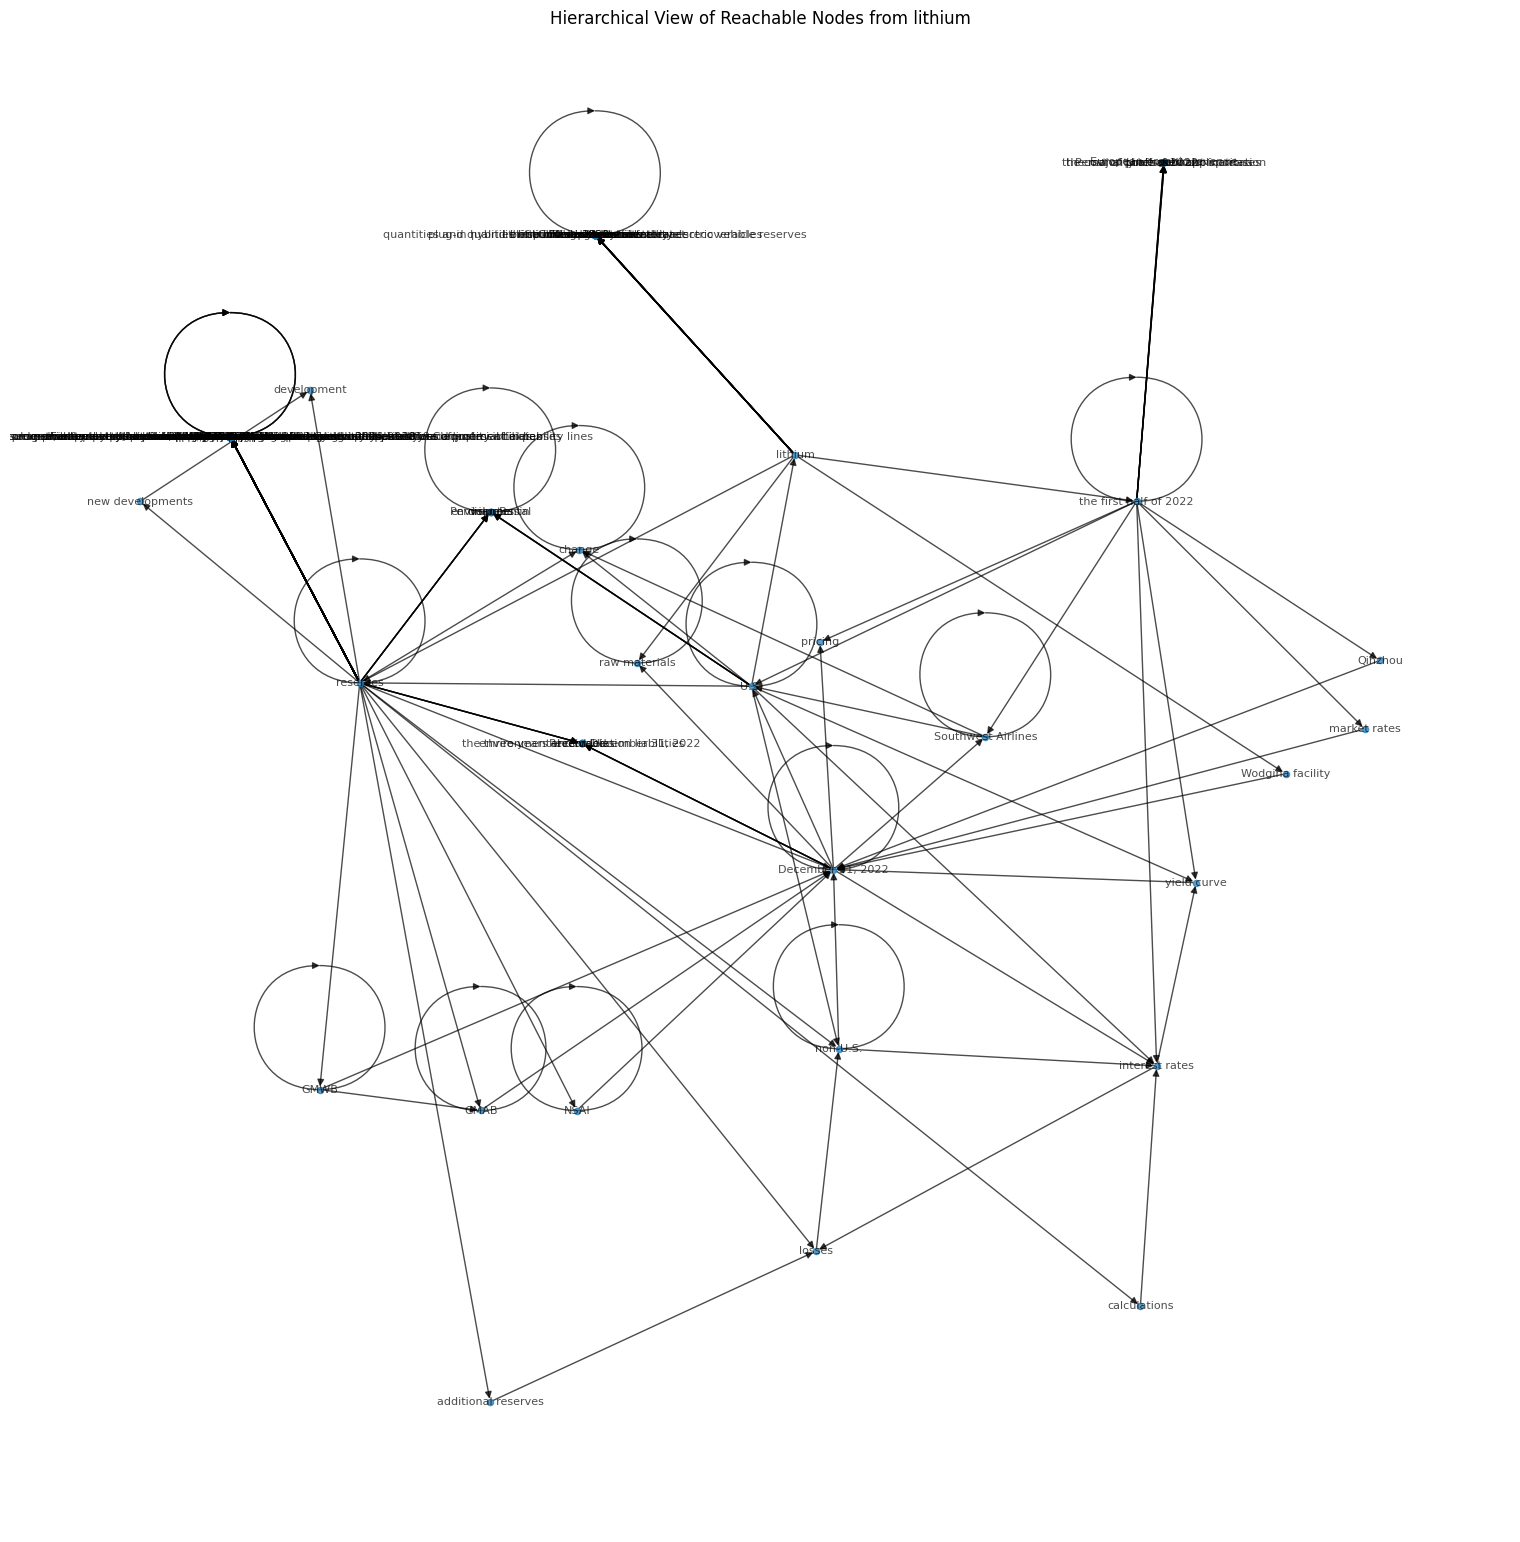

In [85]:
# example with lithium
source_node = 'lithium'
reachable_nodes = nx.single_source_shortest_path_length(G, source_node)
# first 100 reachable nodes
first_100_reachable_nodes = dict(list(reachable_nodes.items())[:100])

# Extract the subgraph of reachable nodes
subgraph = G.subgraph(first_100_reachable_nodes.keys())

# Use the Kamada-Kawai layout for a hierarchical structure
pos = nx.kamada_kawai_layout(subgraph)

# Draw the subgraph with Kamada-Kawai layout
plt.figure(figsize=(15, 15))
nx.draw(subgraph, pos, with_labels=True, node_size=20, font_size=8, alpha=0.7, arrows=True)
plt.title(f"Hierarchical View of Reachable Nodes from {source_node}")
plt.show()

#### source_node와 target_node별 최단 path를 보여줍니다.

In [86]:
# 소스노드와 타겟노드 사이의 최단 path를 보여줍니다.
# find and display the shortest path from one specific node to another in a network
source_node = 'lithium'
# computes the shortest path to all reachable nodes
shortest_paths = nx.single_source_shortest_path(G, source_node)

# can be replaced with other target nodes
target_node = 'Tesla, Inc.'
# target_node is in the keys of the shortest_paths, 
if target_node in shortest_paths:
    path = shortest_paths[target_node]
    print(f"The shortest path from {source_node} to {target_node} is:")
    print(path)
else:
    print(f"There is no path from {source_node} to {target_node}.")

The shortest path from lithium to Tesla, Inc. is:
['lithium', 'the first half of 2022', 'U.S.', '2021', 'Tesla, Inc.']


In [87]:
# when the target_node is replaced from Tesla, Inc. to Tesla
target_node = 'Tesla'
if target_node in shortest_paths:
    path = shortest_paths[target_node]
    print(f"The shortest path from {source_node} to {target_node} is:")
    print(path)
else:
    print(f"There is no path from {source_node} to {target_node}.")

The shortest path from lithium to Tesla is:
['lithium', 'the first half of 2022', 'U.S.', 'California', 'Tesla']


In [88]:
# undirected graph
bi_G = nx.Graph()

for _, row in gpt_just.iterrows():
    bi_G.add_edge(row['source'], row['target'], edge=row['relation'])

In [89]:
source_node = 'lithium'
# compute the shortest path length from the source node to other nodes
reachable_nodes = nx.single_source_shortest_path_length(bi_G, source_node)
# shortest path key = target nodes, valeus = shortest path from the source node to target nodes
shortest_paths = nx.single_source_shortest_path(bi_G, source_node)

# target_node can be replaced with other nodes
target_node = 'Tesla'
# if target_node is present in shortest_paths
if target_node in shortest_paths:
    # retrieves the shortest path from source_node to target_node
    path = shortest_paths[target_node]
    print(f"The shortest path from {source_node} to {target_node} is:")
    print(path)
else:
    print(f"There is no path from {source_node} to {target_node}.")

The shortest path from lithium to Tesla is:
['lithium', 'Tesla']


In [90]:
target_node = 'Tesla, Inc.'  # 'target'을 원하는 목표 노드의 실제 이름으로 바꾸세요.
if target_node in shortest_paths:
    path = shortest_paths[target_node]
    print(f"The shortest path from {source_node} to {target_node} is:")
    print(path)
else:
    print(f"There is no path from {source_node} to {target_node}.")

The shortest path from lithium to Tesla, Inc. is:
['lithium', 'Asia', 'Tesla, Inc.']


Undirected Graph를 통해 시각화합니다.
* source_node = 'lithium'

In [91]:
source_node = 'lithium'
# compute the shortest path length from the source node to other nodes
reachable_nodes = nx.single_source_shortest_path_length(bi_G, source_node)
print(len(list(reachable_nodes.keys())))
# first 100 reachable nodes
first_100_reachable_nodes = dict(list(reachable_nodes.items())[:100])

268602


총 268602개의 reachable_nodes가 있고 연산량이 많아 100개의 노드만을 선택하여 그래프를 구축하였습니다.

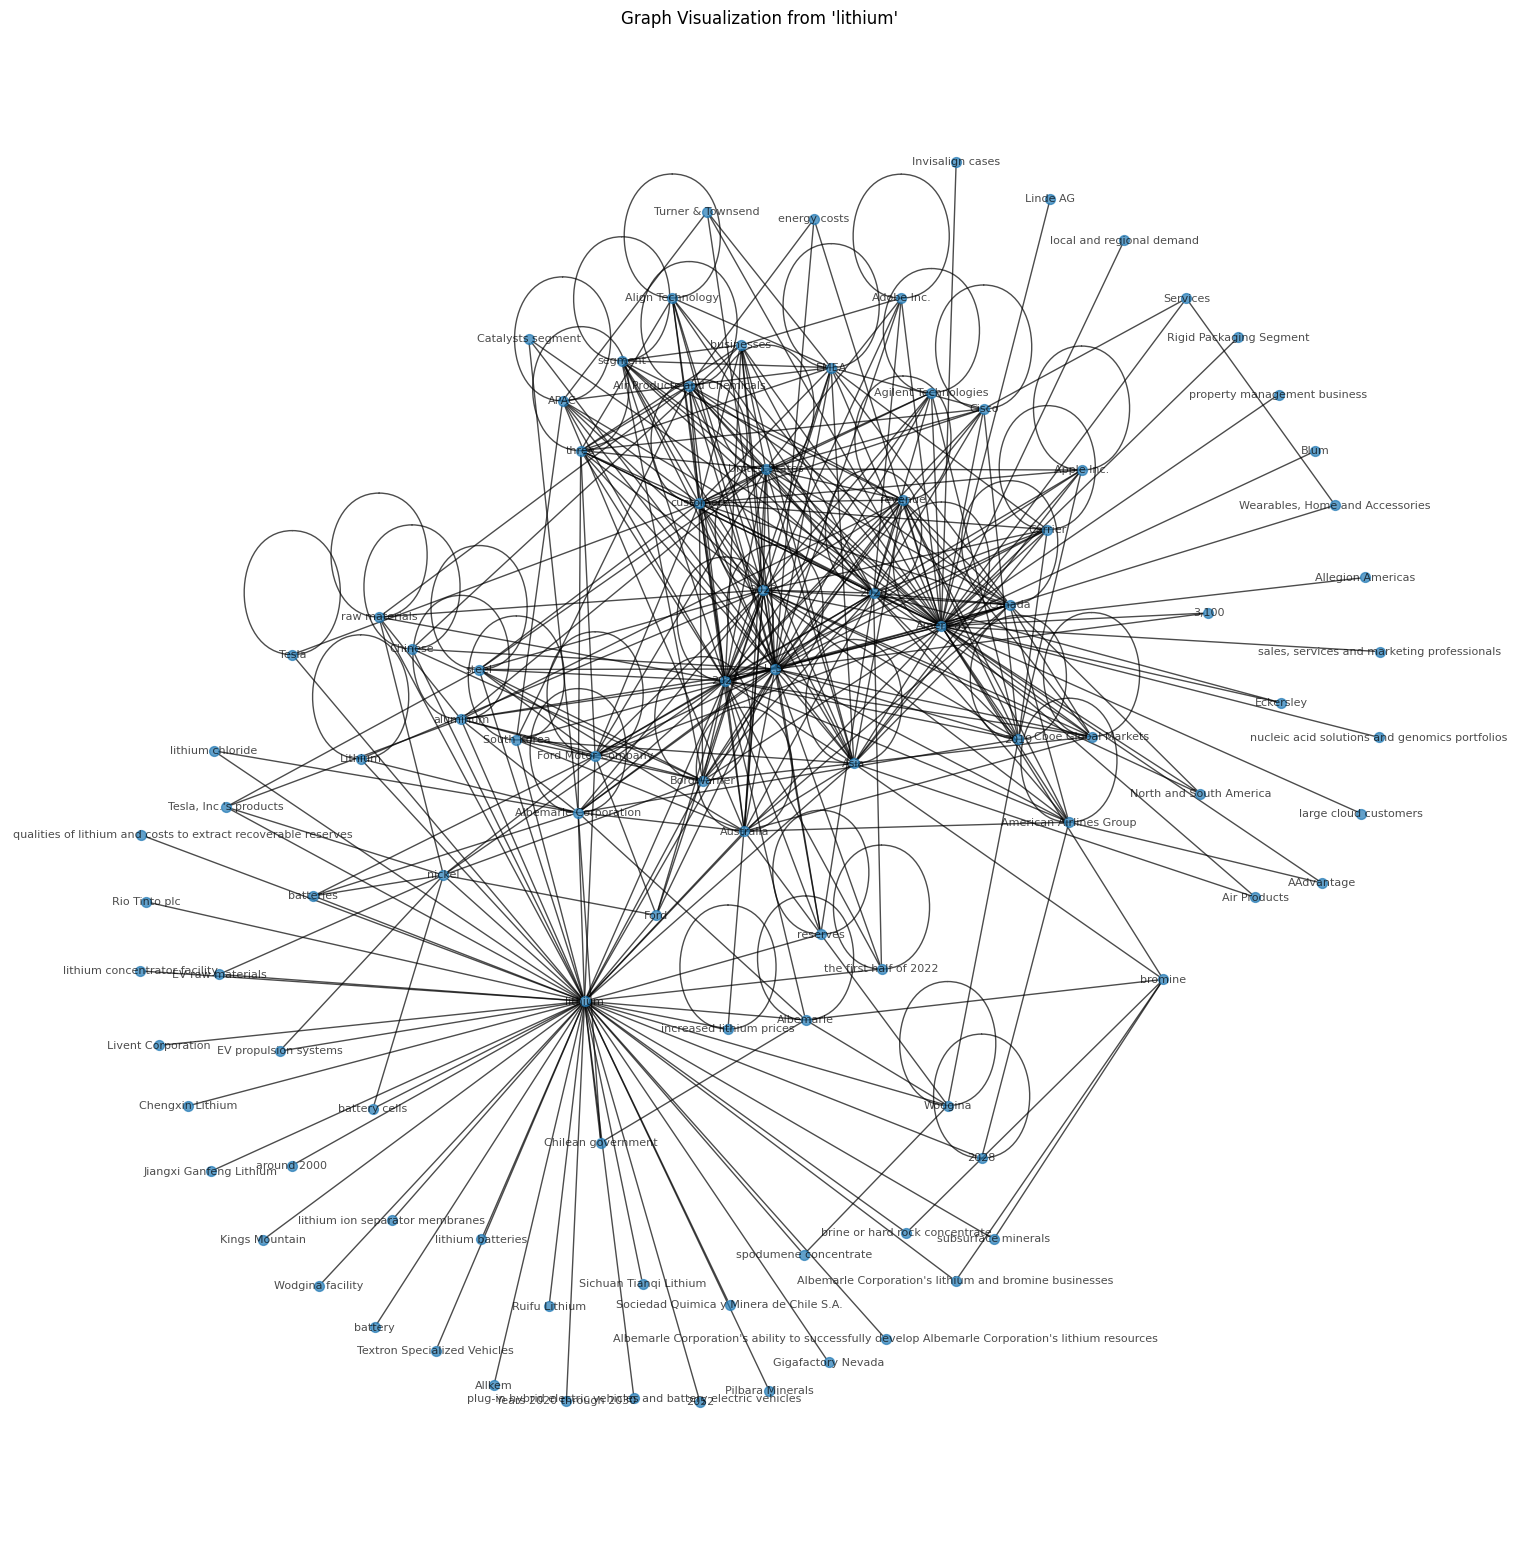

In [92]:
#  도달 가능한 노드만을 포함하는 서브그래프를 추출합니다.
# replaced G with bi_G
subgraph = bi_G.subgraph(first_100_reachable_nodes.keys())

# Kamada-Kawai 레이아웃을 사용하여 서브그래프의 노드 위치를 계산합니다.
pos = nx.kamada_kawai_layout(subgraph)

# 서브그래프를 시각화합니다.
plt.figure(figsize=(15, 15))
nx.draw(subgraph, pos, with_labels=True, node_size=50, font_size=8, alpha=0.7, arrows=True)
plt.title(f"Graph Visualization from '{source_node}'")
plt.show()

아래의 코드는 전체 reachable_nodes에 대한 그래프 입니다. 연산량이 많아 주석처리 되어있습니다.

In [1]:
!jupyter nbconvert --to html final_notebook.ipynb

[NbConvertApp] Converting notebook final_notebook.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 188 image(s).
[NbConvertApp] Writing 268936472 bytes to final_notebook.html


In [1]:
import nbconvert

nbconvert_script = nbconvert.ScriptExporter()
body, _ = nbconvert_script.from_filename("10K_Project.ipynb")

with open("10K_Project.py", "w", encoding="utf-8") as f:
    f.write(body)
